In [1]:
Item referenced:
            https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
            https://github.com/keras-team/keras/issues/3296
            https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html
            https://stackoverflow.com/questions/47535596/how-do-i-get-the-true-labels-when-i-use-a-imagedatagenerator-flow-from-directory?rq=1
            https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator
            https://keras.io/preprocessing/image/

SyntaxError: invalid syntax (<ipython-input-1-c8f5c31aaa67>, line 1)

In [38]:
# improt the nececssary packages and libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications, optimizers
from keras.utils.np_utils import to_categorical
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import math
import cv2

In [39]:
# dimensions of our images.  
img_width, img_height =  150, 150

top_model_weights_path = 'bottleneck_fc_model_weights.h5'
top_model_save_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# number of epochs to train top model  
epochs = 50
# batch size
batch_size = 16
# Hard coded sample sizes
nb_train_samples = 496
nb_validation_samples = 128
n_folds = 3

In [40]:
# This is a function to save the training data features and its labels with the Image Data generator
def save_train_bottlebeck_features(p_train_data_dir, p_img_width, p_img_height, p_batch_size):
    model = applications.VGG16(include_top=False, weights='imagenet')  
    datagen = ImageDataGenerator(rescale=1. / 255)
   
    generator = datagen.flow_from_directory(  
     p_train_data_dir,  
     target_size=(p_img_width, p_img_height),  
     batch_size=p_batch_size,  
     class_mode=None,  
     shuffle=False)  

    l_nb_train_samples = len(generator.filenames)  
    l_num_classes = len(generator.class_indices)
    print("Train num classes ", l_num_classes)

    predict_size_train = int(math.ceil(l_nb_train_samples / float(p_batch_size)))
    print("predict_size_train is ", predict_size_train)
    
    bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train)
    
    print("bottleneck_features_train shape is ", bottleneck_features_train.shape)

    np.save('bottleneck_features_train.npy', bottleneck_features_train) 

In [41]:
def save_validation_bottleneck_features(p_validation_data_dir, p_img_width, p_img_height, p_batch_size):
    model = applications.VGG16(include_top=False, weights='imagenet')  
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    generator = datagen.flow_from_directory(  
     p_validation_data_dir,  
     target_size=(p_img_width, p_img_height),  
     batch_size=p_batch_size,  
     class_mode=None,  
     shuffle=False)  

    l_nb_validation_samples = len(generator.filenames)
    l_num_classes = len(generator.class_indices)
    print("Validation num classes ", l_num_classes)

    predict_size_validation = int(math.ceil(l_nb_validation_samples / float(p_batch_size)))# The float is very important here,
    # else the predict_generator produces smaller numpy array
    print("predict_size_validation is ", predict_size_validation)

    bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
    
    print("bottleneck_features_validation shape is ", bottleneck_features_validation.shape)

    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [42]:
def train_and_evaluate_model(i_fold, train_data, train_labels, p_num_train_classes, validation_data, validation_labels, p_batch_size, p_epochs):
    
    l_num_classes = p_num_train_classes
    model = None
    model = Sequential()  
    model.add(Flatten(input_shape=train_data.shape[1:]))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(l_num_classes, activation='sigmoid'))  

    #model.compile(optimizer='rmsprop',  
    #          loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

    history = model.fit(train_data, train_labels,  
          epochs=p_epochs,  
          batch_size=p_batch_size,  
          validation_data=(validation_data, validation_labels))  

    model.save_weights(top_model_weights_path + str(i_fold))
    model.save(top_model_save_path + str(i_fold))

    (eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=p_batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss))
    
    plt.figure(1)  

    # summarize history for accuracy  

    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

    # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()

In [43]:
def train_top_model(p_train_data_dir, p_validation_data_dir, p_img_width, p_img_height, p_batch_size, p_epochs):
    datagen_top = ImageDataGenerator(rescale=1./255)  
    generator_top = datagen_top.flow_from_directory(  
         p_train_data_dir,  
         target_size=(p_img_width, p_img_height),  
         batch_size=p_batch_size,  
         class_mode='categorical',  
         shuffle=False)  

    l_nb_train_samples = len(generator_top.filenames)  
    l_num_classes = len(generator_top.class_indices)  

    # load the bottleneck features saved earlier  
    train_data = np.load('bottleneck_features_train.npy')  

    # get the class lebels for the training data, in the original order  
    train_labels_b = generator_top.classes  
    #print(train_labels_b)

    # convert the training labels to categorical vectors  
    train_labels = to_categorical(train_labels_b, num_classes=l_num_classes)
    
    generator_top = datagen_top.flow_from_directory(  
         p_validation_data_dir,  
         target_size=(p_img_width, p_img_height),  
         batch_size=p_batch_size,  
         class_mode=None,  
         shuffle=False)  

    l_nb_validation_samples = len(generator_top.filenames)  

    validation_data = np.load('bottleneck_features_validation.npy')  

    validation_labels = generator_top.classes  
    validation_labels = to_categorical(validation_labels, num_classes=l_num_classes)
    #print(train_labels.shape)
    
    skf = StratifiedKFold(train_labels_b, n_folds=n_folds, shuffle=True)

    for i, (e_train, e_test) in enumerate(skf):
            print "Running Fold", i+1, "/", n_folds
            train_and_evaluate_model(i, train_data[e_train], train_labels[e_train], l_num_classes, train_data[e_test], train_labels[e_test], p_batch_size, p_epochs)

Found 509 images belonging to 32 classes.
Found 128 images belonging to 32 classes.
Running Fold 1 / 3
Train on 319 samples, validate on 190 samples
Epoch 1/50
 48/319 [===>..........................] - ETA: 0s - loss: 0.7760 - acc: 0.5410

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input1852") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


319/319 [==============================] - 1s 2ms/step - loss: 0.7187 - acc: 0.5858 - val_loss: 0.5822 - val_acc: 0.6993
Epoch 2/50
319/319 [==============================] - 1s 2ms/step - loss: 0.5835 - acc: 0.6873 - val_loss: 0.4716 - val_acc: 0.8253
Epoch 3/50
319/319 [==============================] - 1s 2ms/step - loss: 0.4984 - acc: 0.7616 - val_loss: 0.4064 - val_acc: 0.9051
Epoch 4/50
319/319 [==============================] - 1s 2ms/step - loss: 0.4495 - acc: 0.8016 - val_loss: 0.3646 - val_acc: 0.9406
Epoch 5/50
319/319 [==============================] - 1s 2ms/step - loss: 0.4178 - acc: 0.8249 - val_loss: 0.3348 - val_acc: 0.9554
Epoch 6/50
319/319 [==============================] - 1s 2ms/step - loss: 0.3970 - acc: 0.8428 - val_loss: 0.3114 - val_acc: 0.9630
Epoch 7/50
319/319 [==============================] - 1s 2ms/step - loss: 0.3783 - acc: 0.8533 - val_loss: 0.2923 - val_acc: 0.9663
Epoch 8/50
319/319 [==============================] - 1s 2ms/step - loss: 0.3618 - acc:

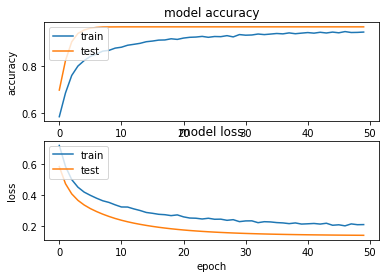

Running Fold 2 / 3
Train on 349 samples, validate on 160 samples
Epoch 1/50
 64/349 [====>.........................] - ETA: 0s - loss: 0.8819 - acc: 0.4419

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2262") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


349/349 [==============================] - 1s 2ms/step - loss: 0.7990 - acc: 0.5028 - val_loss: 0.6184 - val_acc: 0.6441
Epoch 2/50
349/349 [==============================] - 1s 2ms/step - loss: 0.5982 - acc: 0.6757 - val_loss: 0.4648 - val_acc: 0.9137
Epoch 3/50
349/349 [==============================] - 1s 2ms/step - loss: 0.4893 - acc: 0.7821 - val_loss: 0.3905 - val_acc: 0.9588
Epoch 4/50
349/349 [==============================] - 1s 2ms/step - loss: 0.4366 - acc: 0.8238 - val_loss: 0.3465 - val_acc: 0.9658
Epoch 5/50
349/349 [==============================] - 1s 2ms/step - loss: 0.4096 - acc: 0.8435 - val_loss: 0.3154 - val_acc: 0.9686
Epoch 6/50
349/349 [==============================] - 1s 2ms/step - loss: 0.3828 - acc: 0.8591 - val_loss: 0.2907 - val_acc: 0.9688
Epoch 7/50
349/349 [==============================] - 1s 2ms/step - loss: 0.3633 - acc: 0.8699 - val_loss: 0.2704 - val_acc: 0.9688
Epoch 8/50
349/349 [==============================] - 1s 2ms/step - loss: 0.3470 - acc:

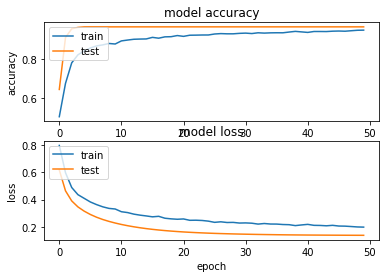

Running Fold 3 / 3
Train on 350 samples, validate on 159 samples
Epoch 1/50
 64/350 [====>.........................] - ETA: 0s - loss: 0.7821 - acc: 0.5171

C:\Python27\Lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2672") expects "<type 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


350/350 [==============================] - 1s 2ms/step - loss: 0.7215 - acc: 0.5667 - val_loss: 0.5742 - val_acc: 0.7134
Epoch 2/50
350/350 [==============================] - 1s 2ms/step - loss: 0.5579 - acc: 0.7179 - val_loss: 0.4490 - val_acc: 0.8994
Epoch 3/50
350/350 [==============================] - 1s 2ms/step - loss: 0.4730 - acc: 0.7963 - val_loss: 0.3873 - val_acc: 0.9314
Epoch 4/50
350/350 [==============================] - 1s 2ms/step - loss: 0.4346 - acc: 0.8244 - val_loss: 0.3473 - val_acc: 0.9412
Epoch 5/50
350/350 [==============================] - 1s 2ms/step - loss: 0.4049 - acc: 0.8427 - val_loss: 0.3172 - val_acc: 0.9485
Epoch 6/50
350/350 [==============================] - 1s 2ms/step - loss: 0.3831 - acc: 0.8584 - val_loss: 0.2932 - val_acc: 0.9554
Epoch 7/50
350/350 [==============================] - 1s 2ms/step - loss: 0.3603 - acc: 0.8709 - val_loss: 0.2730 - val_acc: 0.9615
Epoch 8/50
350/350 [==============================] - 1s 2ms/step - loss: 0.3465 - acc:

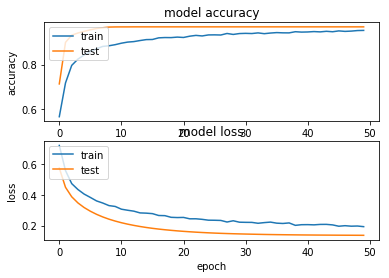

In [44]:
#save_train_bottlebeck_features(train_data_dir, img_width, img_height, batch_size)
#save_validation_bottleneck_features(validation_data_dir, img_width, img_height, batch_size)
train_top_model(train_data_dir, validation_data_dir, img_width, img_height, batch_size, epochs)